<a href="https://colab.research.google.com/github/Andorajaonari/Andorajaonari.github.io/blob/main/cmb_component_separation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install seaborn
!pip install "jax[cpu]"
!pip install numpyro
!pip install arviz

In [ ]:
import arviz as az
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns

import jax
import jax.numpy as jnp
from jax import config
config.update("jax_enable_x64", True)

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, init_to_value

# **Astrophysical Emission Models**

We're going to consider the problem of CMB component separation in total intensity. To make this task straightfoward to run, we'll only be considering the component separation problem for a single pixel (which corresponds to a given line of sight on the sky).

In total intensity, we model the sky as consisting of the following emission components:

1. **Synchrotron**: caused by electrons spiralling in the Galactic magnetic field.
2. **Cosmic Microwave Background (CMB)**: temperature anisotropies in the radiation released after recombination in the early Universe.
3. **Free-free**: caused by electrons scattering off ions (bremsstrahlung emission).
4. **Anomalous Microwave Emission (AME)**: thought to be emitted by spinning dust grains (other ideas include magnetic dust).
5. **Thermal Dust**: caused by thermal radiation from dust grains.

In [ ]:
# Boltzmann Constant
kb = 1.380649e-23
# Planck Constant
h = 6.62607015e-34

**Synchrotron**

We'll be modelling the synchrotron spectral energy distribution (SED) as a curved power law,

$S_s(\nu)=A_s\left(\frac{\nu}{\nu_0^s}\right)^{\beta_s + \frac{1}{2}C_s\log(\nu/\nu_0^s)}$.

The free parameters are $A_s$, $\beta_s$ and $C_s$.

In [ ]:
def synch(nu, nu0, A, beta, C):
    return A * (nu / nu0) ** (beta + 0.5 * C * jnp.log(nu / nu0))

**CMB**

CMB emission follows a blackbody spectrum,

$S_{cmb}(\nu)=A_{cmb}\frac{x^2\exp(x)}{(\exp(x)-1)^2}$,

where $x=\frac{h\nu}{k_{B}T_{cmb}}$ and $T_{cmb}=2.7255\,\mathrm{K}$ is the CMB temperature.

The free parameter is $A_{cmb}$.

In [ ]:
def cmb(nu, Tcmb, A):
    x = h * nu / (kb * Tcmb)
    return A * x ** 2 * jnp.exp(x) / (jnp.exp(x) - 1.0) ** 2

**Free-free**

For free-free emission we will use the Planck diffuse component model (see Planck 2015, Diffuse Component Separation),

$S_{ff}(\nu) = T_e(1-\exp(-\tau))$,

where $\tau=0.05468 T_e^{-3/2}\left(\frac{\nu}{10^9}\right)^{-2}\mathrm{EM} g_{ff}$, and the Gaunt factor is given by

$g_{ff}=\log\left[\exp\left(5.96 - \frac{\sqrt{3}}{\pi}\log\left(\frac{\nu}{10^9}\left(\frac{T_e}{10^4}\right)^{-3/2}\right)\right) + e\right]$.

The free parameters are $T_e$ and $\mathrm{EM}$.

In [ ]:
def ff(nu, Te, EM):
    nu9 = nu / 1e9
    T4 = Te / 1e4
    gff = jnp.log(jnp.exp(5.96 - jnp.sqrt(3.0) * jnp.log(nu9 * T4 ** (-1.5)) / jnp.pi) + jnp.exp(1.0))
    tau = 0.05468 * Te ** (-1.5) * nu9 ** (-2.0) * EM * gff
    return Te * (1.0 - jnp.exp(-tau))

**Anomalous Microwave Emission**

For AME we will adopt a log-normal emission model,

$S_{ame}(\nu)=A_{ame}\exp\left(-\frac{1}{2}\left[\frac{\log(\nu/\nu_{ame})}{W_{ame}}\right]^2\right)$.

The free parameters are $A_{ame}$, $\nu_{ame}$ and $W_{ame}$.

In [ ]:
def ame(nu, v, w, A):
    return A * jnp.exp(-0.5 * (jnp.log(nu / v) / w) ** 2)

**Thermal Dust**

For thermal dust emission we will use a modified blackbody spectrum,

$S_d(\nu)=A_d\left(\frac{\nu}{\nu_0^d}\right)^{\beta_d + 1}\frac{\exp(\gamma\nu_0^d)-1}{\exp(\gamma\nu-1)}$,

where $\gamma=\frac{h}{k_B T_d}$.

The free parameters are $A_d$, $\beta_d$ and $T_d$.

In [ ]:
def dust(nu, nu0, A, beta, Td):
    gamma = h / (kb * Td)
    return A * (nu / nu0) ** (beta + 1.0) * (jnp.exp(gamma * nu0) - 1.0) / (jnp.exp(gamma * nu) - 1.0)

# **Experimental Configurations**

These frequencies and sensitivities are taken from L. Jew et al., 2019 (https://arxiv.org/abs/1907.11642). The experiments included in the simulation are:

1. C-Band All-Sky Survey (C-BASS): observing low-frequency emission at 5 GHz.
2. Haslam: observing low-frequency emission at 408 MHz.
3. WMAP: CMB experiment covering frequencies from 23 - 95 GHz.
4. Planck: CMB experiment covering frequencies from 28.4 - 857 GHz.

This gives us a total of 16 data points (observed frequencies). Our model will have a total of 12 free parameters.

In [ ]:
freqs = jnp.array([5.0, 0.408, 23.0, 33.0, 41.0, 61.0, 95.0, 28.4,
                   44.1, 70.4, 100.0, 143.0, 217.0, 353.0, 545.0, 857.0])
freqs *= 1e9 # Frequencies in Hz

sigma = jnp.array([73.0, 2.5e6, 5.82, 4.18, 3.52, 3.79, 3.92, 2.45, 2.57,
                   3.08, 1.00, 0.333, 0.261, 0.198, 0.0855, 0.0319])
sigma *= 1e-6 # Sensitivities in mK

# **Spectral Energy Distribution Simulations**

We will generate a simulation of the true sky. The values I have chosen here correspond roughly with the emission found in the Lambda-Orionis region (R. Cepeda-Arroita et al. 2021, https://arxiv.org/abs/2001.07159).

To generate our simulated data, we will add Gaussian noise corresponding to experimental sensitivities defined above. The observed sky signal is given by

$d(\nu)=S_{s}(\nu)+S_{cmb}(\nu)+S_{ff}(\nu)+S_{ame}(\nu)+S_d(\nu)+\eta_\nu=S(\nu)+\eta_\nu$,

where $\eta_\nu\sim\mathcal{N}(0,\sigma_\nu^2)$ is the instrumental noise at each frequency.

In [ ]:
# Synchrotron parameters
As = 22.7
beta_s = -3.1
Cs = 0.05
nu0_s = 0.408e9

# CMB parameters
Acmb = 75.0e-6
Tcmb = 2.7255

# Free-Free parameters
Te = 7000.0
EM = 331.0

# AME parameters
Aame = 207.0e-6
Wame = 0.51
nu_ame = 23.97e9

# Dust parameters
Ad = 448.0e-6
beta_d = 1.48
Td = 21.2
nu0_d = 545.0e9

In [ ]:
# True astrophysical emission

true_synch = synch(freqs, nu0_s, As, beta_s, Cs)
true_cmb = cmb(freqs, Tcmb, Acmb)
true_ff = ff(freqs, Te, EM)
true_ame = ame(freqs, nu_ame, Wame, Aame)
true_dust = dust(freqs, nu0_d, Ad, beta_d, Td)

plot_nu = jnp.linspace(0.1, 1000, 2000) * 1e9
plot_synch = synch(plot_nu, nu0_s, As, beta_s, Cs)
plot_cmb = cmb(plot_nu, Tcmb, Acmb)
plot_ff = ff(plot_nu, Te, EM)
plot_ame = ame(plot_nu, nu_ame, Wame, Aame)
plot_dust = dust(plot_nu, nu0_d, Ad, beta_d, Td)

In [ ]:
# Noisy signal
true_total = true_synch + true_cmb + true_ff + true_ame + true_dust
plot_total = plot_synch + plot_cmb + plot_ff + plot_ame + plot_dust
noisy_signal = true_total + jax.random.normal(jax.random.PRNGKey(0), shape=(len(true_total),)) * sigma

**Simulated Sky Emission**

Let's plot up the simulated emission components and the total sky emission. The observed sky signal at each of the experiment frequencies are shown as pink dots.

Text(0, 0.5, '$s(\\nu)$ $[K_{RJ}]$')

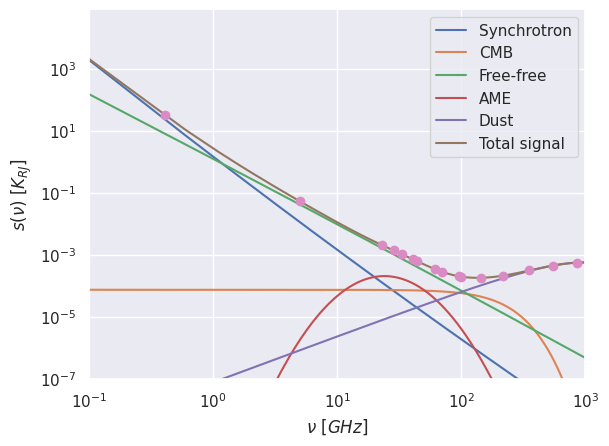

In [ ]:
# Plot SEDs
sns.set_theme()
plt.figure()
plt.loglog(plot_nu / 1e9, plot_synch, label='Synchrotron')
plt.loglog(plot_nu / 1e9, plot_cmb, label='CMB')
plt.loglog(plot_nu / 1e9, plot_ff, label='Free-free')
plt.loglog(plot_nu / 1e9, plot_ame, label='AME')
plt.loglog(plot_nu / 1e9, plot_dust, label='Dust')
plt.loglog(plot_nu / 1e9, plot_total, label='Total signal')
plt.legend()
plt.errorbar(freqs / 1e9, noisy_signal, yerr=sigma, fmt='o')
plt.xlim(0.1, 1e3)
plt.ylim(1e-7)
plt.xlabel(r'$\nu$ $[GHz]$')
plt.ylabel(r'$s(\nu)$ $[K_{RJ}]$')

# **Numpyro Model**

Now we've defined our emission models, and obtained our dataset, we're ready to use numpyro to perform Bayesian CMB component separation.

If you look at the `signal_model` function below you will see that the code looks quite similar in structure to how one would write out the statistical model. We'll start with the priors,

$A_s\sim|\mathcal{N}(\mu=0, \sigma^2=2^2)|$

$\beta_s\sim\mathcal{N}(\mu=-3.1, \sigma^2=0.5^2)$

$C_s\sim\mathcal{N}(\mu=0, \sigma=1^2)$

$A_{cmb}\sim\mathcal{N}(\mu=0, \sigma^2=1^2)$

$T_e\sim\mathrm{InvGamma}(\alpha=2, \beta=7)$

$\mathrm{EM}\sim|\mathcal{N}(\mu=0, \sigma^2=3^2)|$

$\mathrm{A}_{ame}\sim|\mathcal{N}(\mu=0, \sigma^2=2^2)|$

$\nu_{ame}\sim|\mathcal{N}(\mu=0, \sigma^2=2^2)|$

$W_{ame}\sim|\mathcal{N}(\mu=0, \sigma^2=0.5^2)|$

$A_d\sim\mathrm{InvGamma}(\alpha=2, \beta=4.5)$

$\beta_d\sim\mathcal{N}(\mu=1.5, \sigma^2=0.1^2)$

$T_d\sim\mathrm{InvGamma}(\alpha=2, \beta=2)$

Let $\Theta$ denote all of our model parameters. The model sky emission for a given set of model parameters is $S(\nu,\Theta)$. We have a Gaussian likelihood, which corresponds to our data being distributed as,

$d_\nu\sim\mathcal{N}(S(\nu, \Theta),\sigma_\nu^2)$

Note that in the model definition I have rescaled all the variables so they're approximately on the unit scale. This is good practice in general, and will make your sampler perform much better. If you want to do a deep dive into this, you can read into preconditioning for MCMC algorithms.

In [ ]:
def signal_model(data,
                 sigma,
                 nu=freqs,
                 nu0_s=nu0_s,
                 Tcmb=Tcmb,
                 nu0_d=nu0_d):

    # Synchrotron parameters
    As = numpyro.sample('As', dist.HalfNormal(2.0))
    beta_s = numpyro.sample('beta_s', dist.Normal(-3.1, 0.5))
    Cs = numpyro.sample('Cs', dist.Normal(0.0, 1.0))

    # CMB parameters
    Acmb = numpyro.sample('Acmb', dist.Normal(0.0, 1.0))

    # Free-free parameters
    Te = numpyro.sample('Te', dist.InverseGamma(2.0, 0.7))
    EM = numpyro.sample('EM', dist.HalfNormal(3.0))

    # AME parameters
    Aame = numpyro.sample('Aame', dist.HalfNormal(2.0))
    nu_ame = numpyro.sample('nu_ame', dist.HalfNormal(2.0))
    Wame = numpyro.sample('Wame', dist.HalfNormal(0.5))

    # Dust parameters
    Ad = numpyro.sample('Ad', dist.InverseGamma(2.0, 4.5))
    beta_d = numpyro.sample('beta_d', dist.Normal(1.5, 0.1))
    Td = numpyro.sample('Td', dist.InverseGamma(2.0, 2.0))

    synch_signal = synch(nu, nu0_s, As * 10.0, beta_s, Cs / 10.0)
    cmb_signal = cmb(nu, Tcmb, Acmb * 1e-4)
    ff_signal = ff(nu, Te * 1e4, EM * 1e2)
    ame_signal = ame(nu, nu_ame * 1e10, Wame, Aame * 1e-4)
    dust_signal = dust(nu, nu0_d, Ad * 1e-4, beta_d, Td * 10.0)
    total_signal = synch_signal + cmb_signal + ff_signal + ame_signal + dust_signal

    llk = numpyro.sample('llk', dist.Normal(total_signal, sigma), obs=data)

In the cell below we'll run the No-U-Turn (NUTS) sampler on our component separation problem. Here are a few things to note:

1. I initialize the sampler at the true parameters values. This helps a lot in this case because it means the sampler doesn't have to do a long burn-in towards the typical set. You can try looking at how the performance is affected if you change the initialization. Of course, in general you won't know the true parameter values, so you need to give a bit more thought to how you initialize your Markov chain.

2. `max_tree_depth` sets the maximum number of trajectory doublings NUTS will perform in trying to detect a U-turn. This prevents overly long trajectories. For most standard problems you won't need to worry about this. However, if you have e.g., a very expensive forward model, you may want to reduce this to avoid computing the forward model too frequently.

3. `target_accept_prob` sets the target Metropolis-Hastings acceptance probability that the algorithm will tune the step size for (smaller step size gives higher acceptance probability). You can try varying this to see how it impacts the sampler. For models with challenging geometries e.g., rapidly varying curvature, you may need to use higher values (e.g., >0.9) in order to avoid divergences. Divergences occur when the value of the Hamiltonian diverges during sampling (it should be constant). This can be indicative of a region of the posterior where the curvature cannot be resolved by the given step size (for those who are interested, this means we cannot be sure of satifying geometric ergodicity). Divergences are a very important convergence diagnostic available to HMC.

4. `dense_mass` controls whether to use an estimate of the full target covariance (True) to rescale the parameters, or whether to use the diagonal target covariance estimate (False). Using the dense mass matrix can help by both rescaling and rotating (helping to deal with parameter correlations), but means you have to do dense matrix manipulations at each sampling step, so doesn't scale well with dimension.

5. `num_warmup` sets the number of tuning samples. During this phase the sampler is adapted to the given problem. At the end of tuning we discard these samples (these are not valid samples because the Markov transition kernel is being adapted).

6. `num_samples` sets the number of samples we draw.

In [ ]:
init_strategy = init_to_value(
                    values={"As": 2.27,
                            "beta_s": -3.1,
                            "Cs": 0.5,
                            "Acmb": 0.75,
                            "Te": 0.7,
                            "EM": 3.31,
                            "Aame": 2.07,
                            "nu_ame": 2.397,
                            "Wame": 0.51,
                            "Ad": 4.48,
                            "beta_d": 1.48,
                            "Td": 2.12}
                             )

mcmc = MCMC(
        NUTS(signal_model,
             max_tree_depth=10,
             target_accept_prob=0.98,
             dense_mass=False,
             init_strategy=init_strategy),
        num_warmup=10000,
        num_samples=10000,
        progress_bar=True
    )
mcmc.run(jax.random.PRNGKey(10), noisy_signal, sigma)
mcmc.print_summary()

sample: 100%|██████████| 20000/20000 [01:14<00:00, 269.52it/s, 1023 steps of size 2.13e-03. acc. prob=0.98]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      Aame      1.79      0.64      1.64      0.94      2.65    688.52      1.00
      Acmb      0.72      0.03      0.72      0.68      0.77    843.57      1.00
        Ad      4.48      0.00      4.48      4.48      4.48   1289.04      1.00
        As      2.35      0.26      2.35      1.93      2.78   2805.33      1.00
        Cs     -0.04      0.99     -0.05     -1.65      1.60   2648.41      1.00
        EM      3.08      0.67      2.97      2.10      4.11   1255.18      1.00
        Td      2.13      0.01      2.13      2.11      2.14   1463.32      1.00
        Te      0.54      0.60      0.40      0.09      1.03   1877.49      1.00
      Wame      0.48      0.07      0.47      0.37      0.58    758.37      1.00
    beta_d      1.48      0.00      1.48      1.47      1.48   1511.50      1.00
    beta_s     -3.22      0.17     -3.22     -3.50     -2.92   1037.85      1.00
    nu_ame      2.58      0

In [ ]:
mcmc_samples = mcmc.get_samples()
idata = az.from_numpyro(mcmc)

**Traceplots**

We can visualize the sampling process using a traceplot ...

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


array([[<Axes: title={'center': 'Aame'}>,
        <Axes: title={'center': 'Aame'}>],
       [<Axes: title={'center': 'Acmb'}>,
        <Axes: title={'center': 'Acmb'}>],
       [<Axes: title={'center': 'Ad'}>, <Axes: title={'center': 'Ad'}>],
       [<Axes: title={'center': 'As'}>, <Axes: title={'center': 'As'}>],
       [<Axes: title={'center': 'Cs'}>, <Axes: title={'center': 'Cs'}>],
       [<Axes: title={'center': 'EM'}>, <Axes: title={'center': 'EM'}>],
       [<Axes: title={'center': 'Td'}>, <Axes: title={'center': 'Td'}>],
       [<Axes: title={'center': 'Te'}>, <Axes: title={'center': 'Te'}>],
       [<Axes: title={'center': 'Wame'}>,
        <Axes: title={'center': 'Wame'}>],
       [<Axes: title={'center': 'beta_d'}>,
        <Axes: title={'center': 'beta_d'}>],
       [<Axes: title={'center': 'beta_s'}>,
        <Axes: title={'center': 'beta_s'}>],
       [<Axes: title={'center': 'nu_ame'}>,
        <Axes: title={'center': 'nu_ame'}>]], dtype=object)

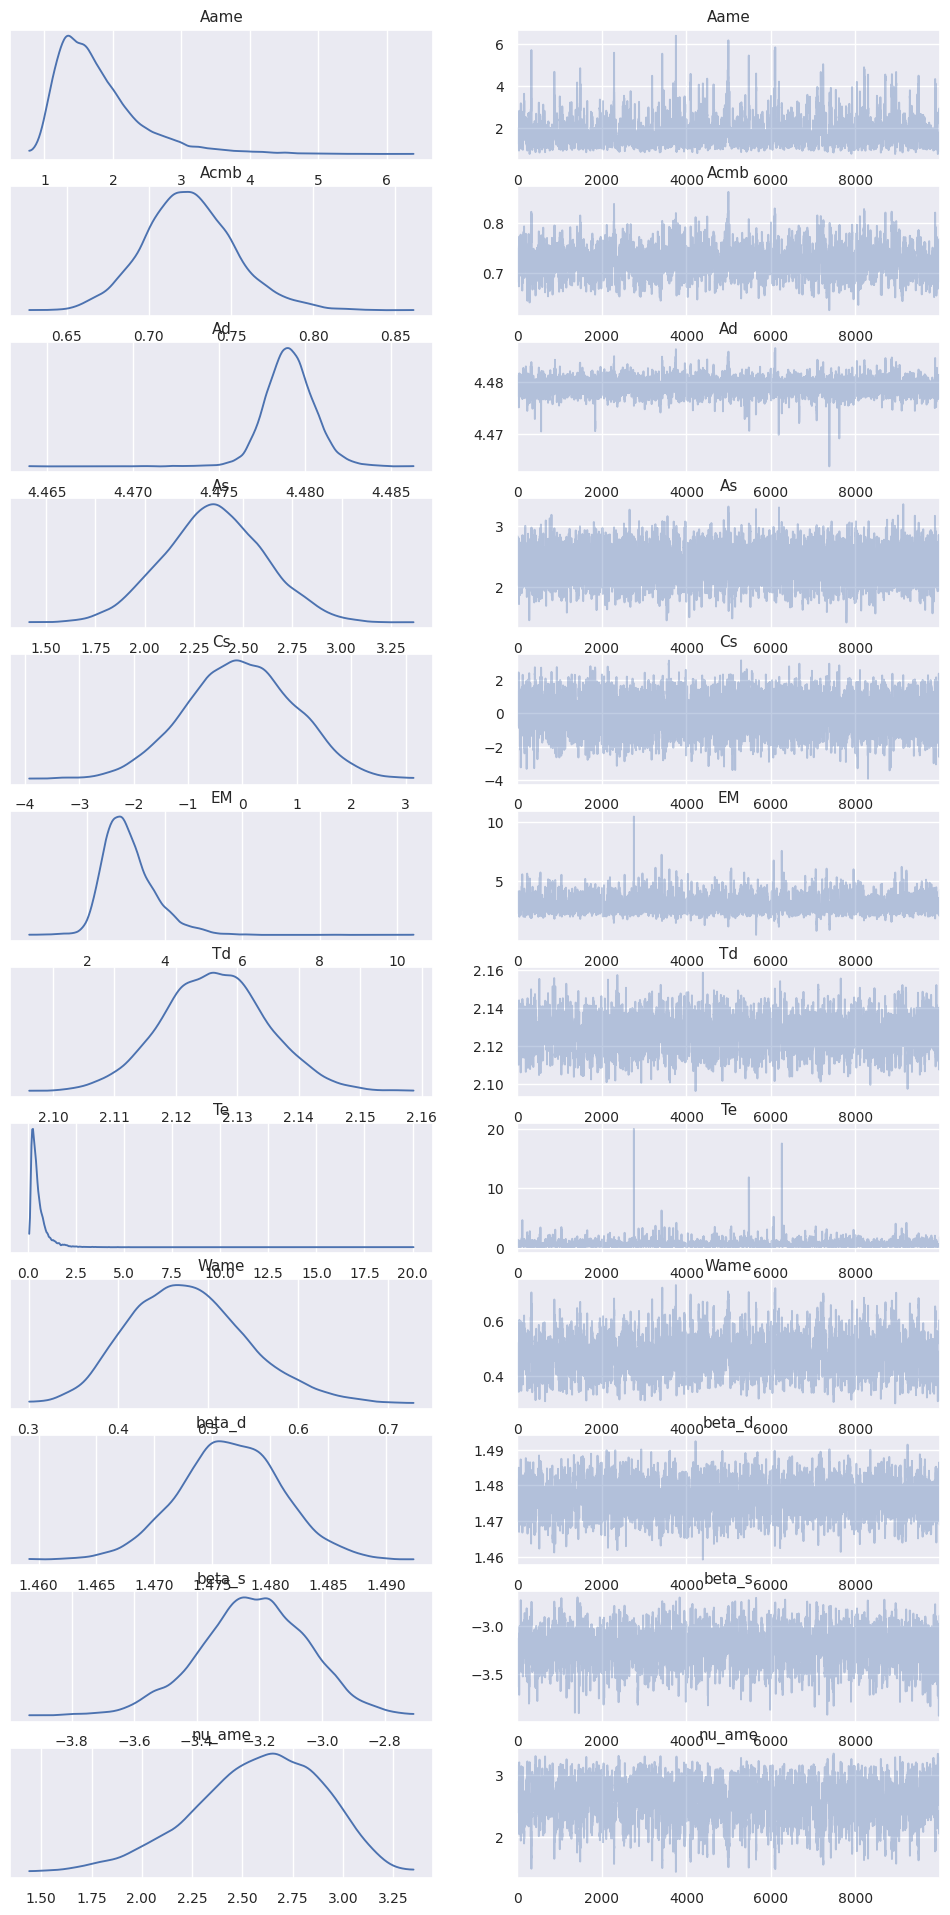

In [ ]:
az.plot_trace(idata)

**Pairplot**

We can also look at a pairplot, where we can see pairwise correlations between parameters.

/usr/local/lib/python3.10/dist-packages/arviz/plots/backends/matplotlib/pairplot.py:232: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  warnings.warn(


array([[<Axes: ylabel='Acmb'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='Ad'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='As'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='Cs'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='EM'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='Td'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='Te'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: xlabel='Aame', ylabel='Wame'>, <Axes: xlabel='Acmb'>,
        <Axes: xlabel='Ad'>, <Axes: xlabel='As'>, <Axes: xlabel='Cs'>,
        <Axes: xlabel='EM'>, <Axes: xlabel='Td'>, <Axes: xlabel='Te'>]],
      dtype=object)

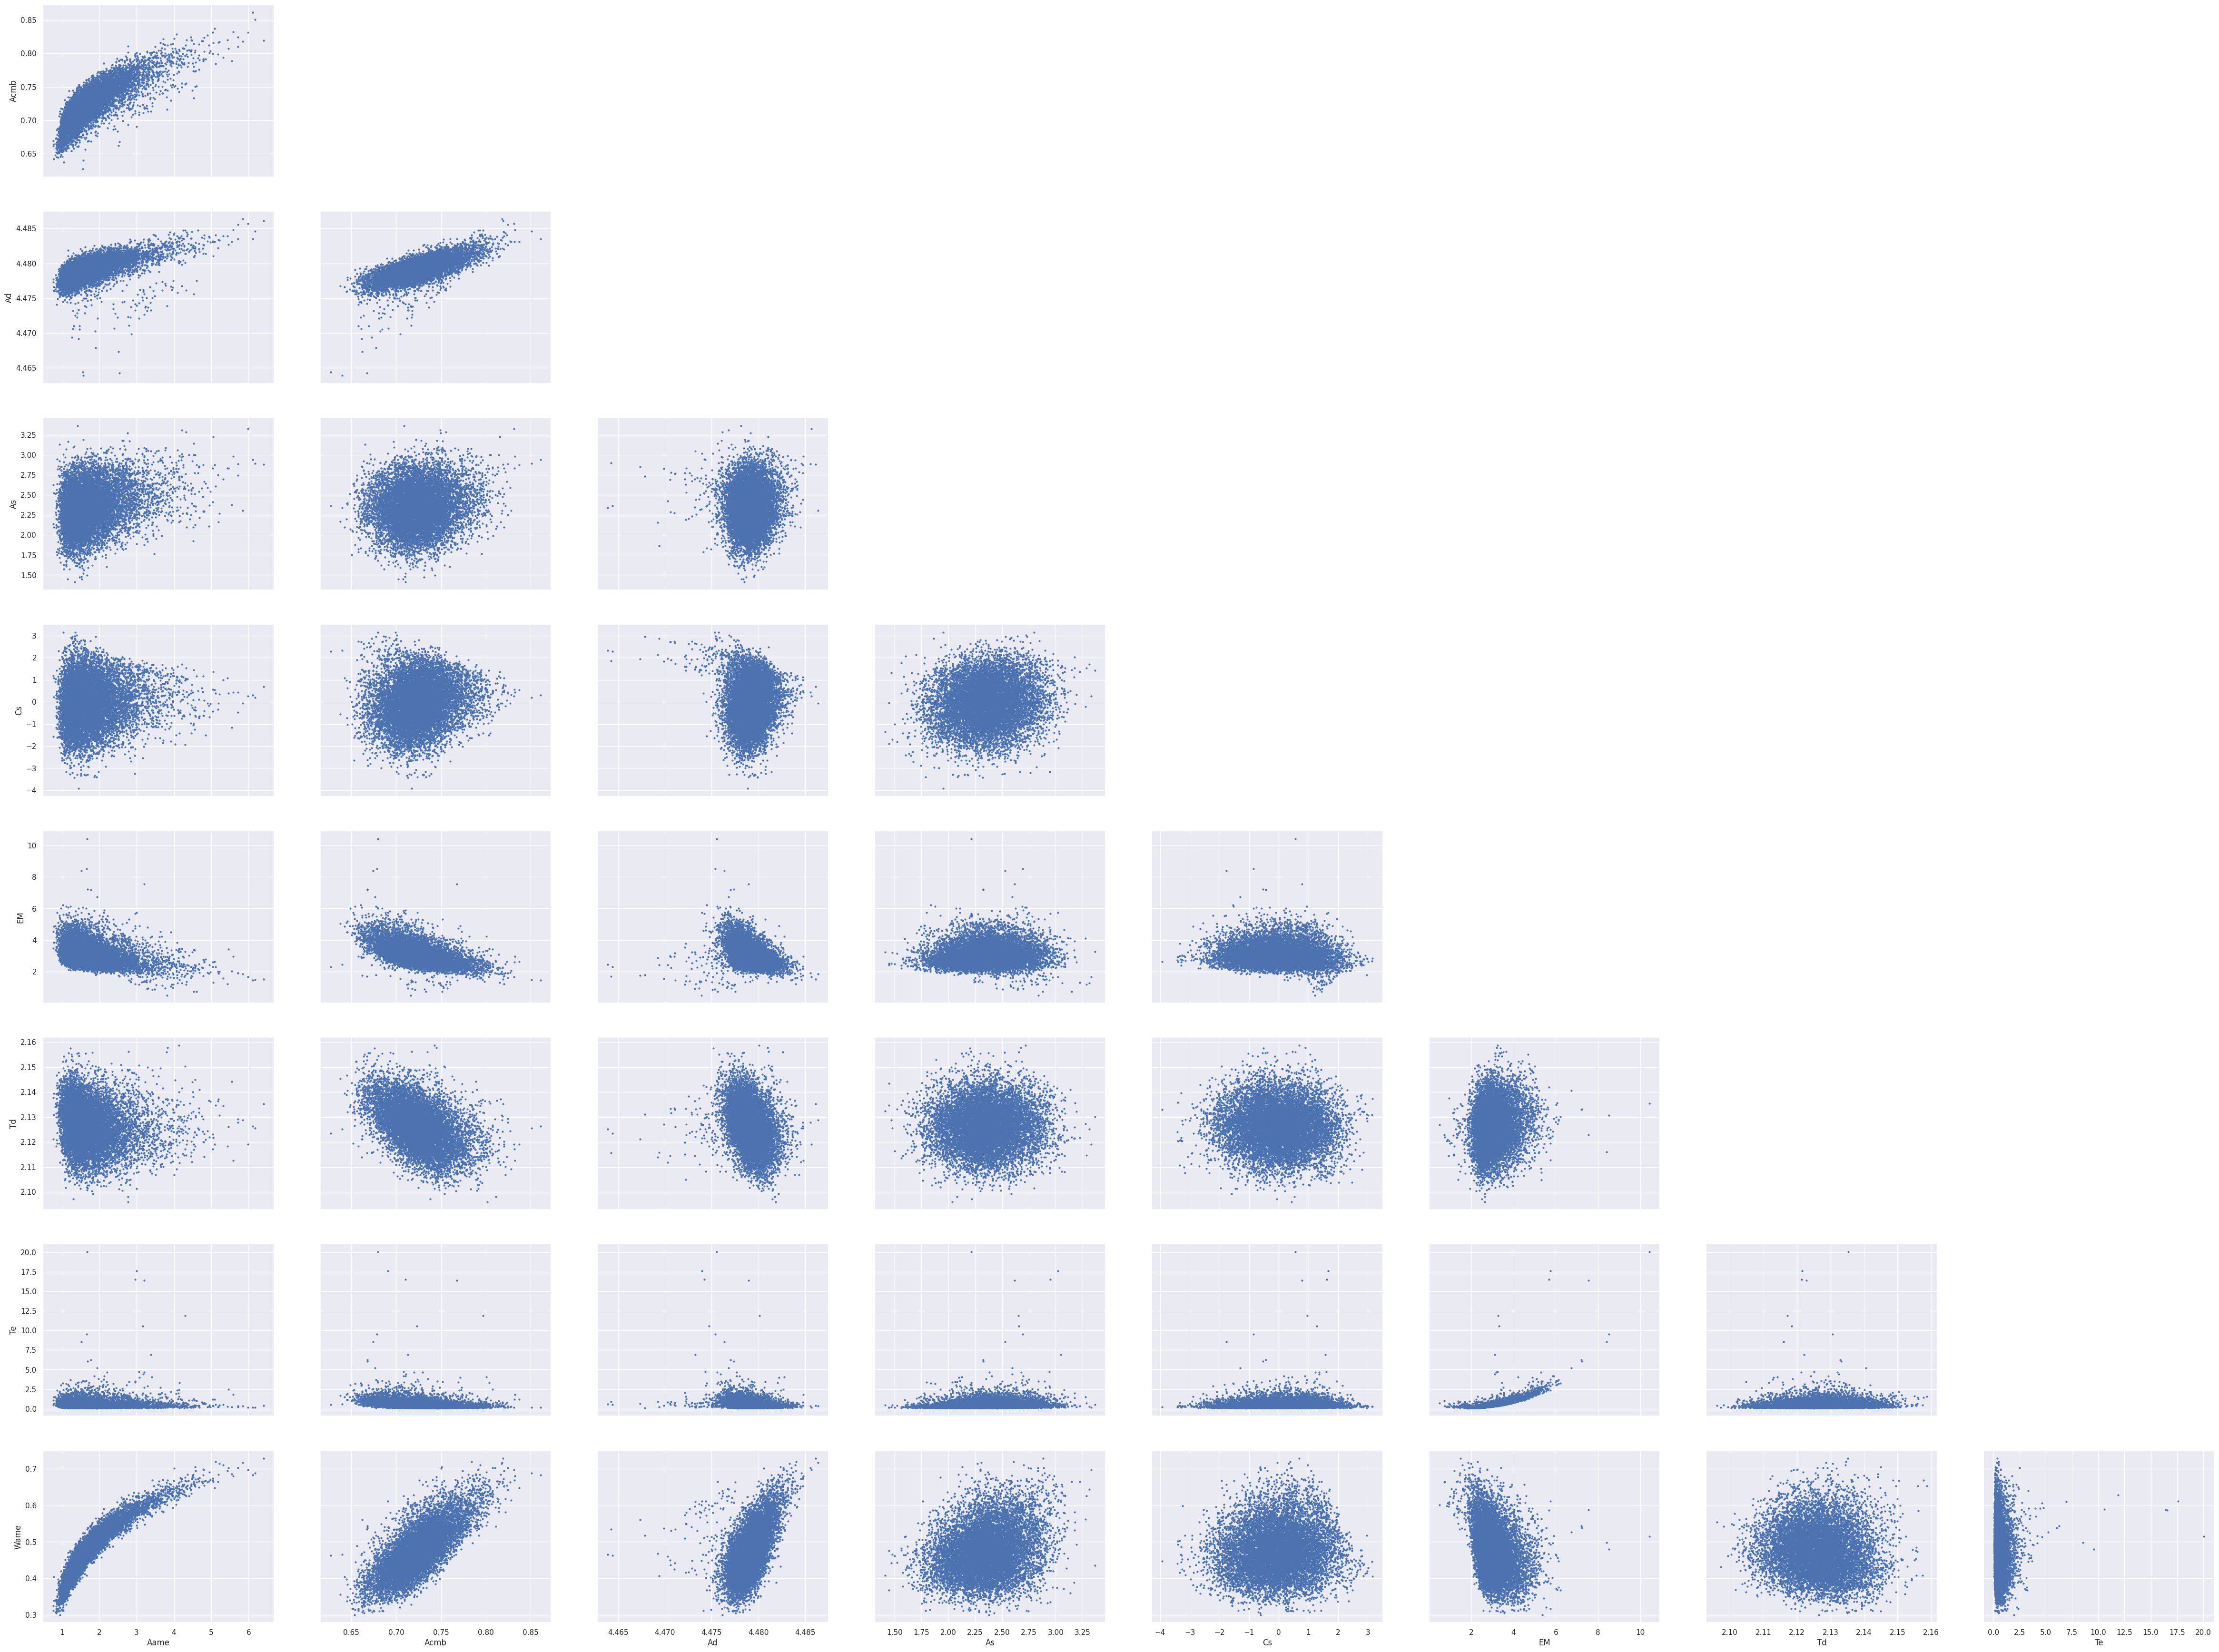

In [ ]:
az.plot_pair(idata)

# **Posterior Predictive Samples**

Given our posterior samples, we can look at the recovered emission components by pushing MCMC samples through the emission models.

In the final plot, we'll look at the total recovered signal. This can be compared against the data in what is known as posterior predicitive checking. For an intro to this you can see https://mc-stan.org/docs/2_23/stan-users-guide/posterior-prediction-chapter.html.

Posterior predicitive checks form and important part of model checking and validation, that should be a part of a good statistical workflow.

In [ ]:
idx = jnp.arange(0, len(mcmc_samples['As']), step=100)

In [ ]:
post_synch = []
for i in idx:
    post_synch.append(synch(plot_nu,
                            nu0_s,
                            mcmc_samples['As'][i] * 10.0,
                            mcmc_samples['beta_s'][i],
                            mcmc_samples['Cs'][i] / 10.0))

mean_synch = synch(plot_nu,
                   nu0_s,
                   jnp.mean(mcmc_samples['As'] * 10.0),
                   jnp.mean(mcmc_samples['beta_s']),
                   jnp.mean(mcmc_samples['Cs'] / 10.0))

In [ ]:
post_cmb = []
for i in idx:
    post_cmb.append(cmb(plot_nu,
                        Tcmb,
                        mcmc_samples['Acmb'][i] * 1e-4))

mean_cmb = cmb(plot_nu,
               Tcmb,
               jnp.mean(mcmc_samples['Acmb'] * 1e-4))

In [ ]:
post_ff = []
for i in idx:
    post_ff.append(ff(plot_nu,
                      mcmc_samples['Te'][i] * 1e4,
                      mcmc_samples['EM'][i] * 1e2))

mean_ff = ff(plot_nu,
             jnp.mean(mcmc_samples['Te'] * 1e4),
             jnp.mean(mcmc_samples['EM'] * 1e2))

In [ ]:
post_ame = []
for i in idx:
    post_ame.append(ame(plot_nu,
                        mcmc_samples['nu_ame'][i] * 1e10,
                        mcmc_samples['Wame'][i],
                        mcmc_samples['Aame'][i] * 1e-4))

mean_ame = ame(plot_nu,
               jnp.mean(mcmc_samples['nu_ame'] * 1e10),
               jnp.mean(mcmc_samples['Wame']),
               jnp.mean(mcmc_samples['Aame'] * 1e-4))

In [ ]:
post_dust = []
for i in idx:
    post_dust.append(dust(plot_nu,
                          nu0_d,
                          mcmc_samples['Ad'][i] * 1e-4,
                          mcmc_samples['beta_d'][i],
                          mcmc_samples['Td'][i] * 10.0))

mean_dust = dust(plot_nu,
                 nu0_d,
                 jnp.mean(mcmc_samples['Ad'] * 1e-4),
                 jnp.mean(mcmc_samples['beta_d']),
                 jnp.mean(mcmc_samples['Td'] * 10.0))

In [ ]:
post_total = jnp.array(post_synch) + jnp.array(post_cmb) + jnp.array(post_ff) + jnp.array(post_ame) + jnp.array(post_dust)
mean_total = mean_synch + mean_cmb + mean_ff + mean_ame + mean_dust

Text(0, 0.5, '$s(\\nu)$ $[K_{RJ}]$')

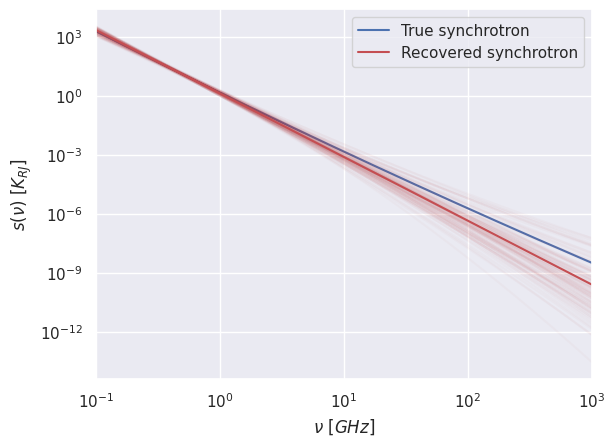

In [ ]:
# Synchrotron signal
plt.figure()
plt.loglog(plot_nu / 1e9, plot_synch, label='True synchrotron')
for i, post_signal in enumerate(post_synch):
    plt.loglog(plot_nu / 1e9, post_signal, alpha=0.03, color='r')
plt.loglog(plot_nu / 1e9, mean_synch, alpha=1.0, color='r', label='Recovered synchrotron')
plt.legend()
plt.xlim(0.1, 1e3)
plt.xlabel(r'$\nu$ $[GHz]$')
plt.ylabel(r'$s(\nu)$ $[K_{RJ}]$')

Text(0, 0.5, '$s(\\nu)$ $[K_{RJ}]$')

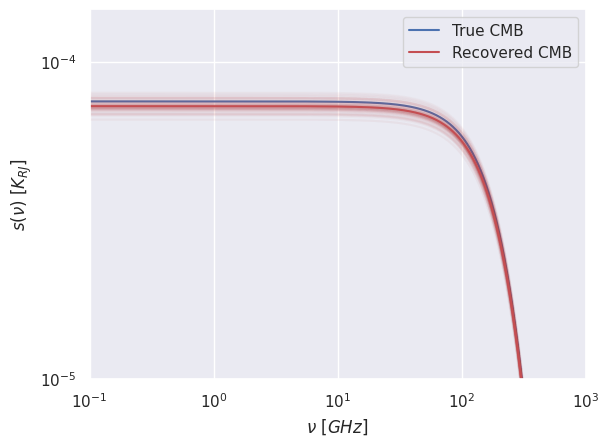

In [ ]:
# CMB signal
plt.figure()
plt.loglog(plot_nu / 1e9, plot_cmb, label='True CMB')
for i, post_signal in enumerate(post_cmb):
    plt.loglog(plot_nu / 1e9, post_signal, alpha=0.03, color='r')
plt.loglog(plot_nu / 1e9, mean_cmb, alpha=1.0, color='r', label='Recovered CMB')
plt.legend()
plt.ylim(1e-5)
plt.xlim(0.1, 1e3)
plt.xlabel(r'$\nu$ $[GHz]$')
plt.ylabel(r'$s(\nu)$ $[K_{RJ}]$')

Text(0, 0.5, '$s(\\nu)$ $[K_{RJ}]$')

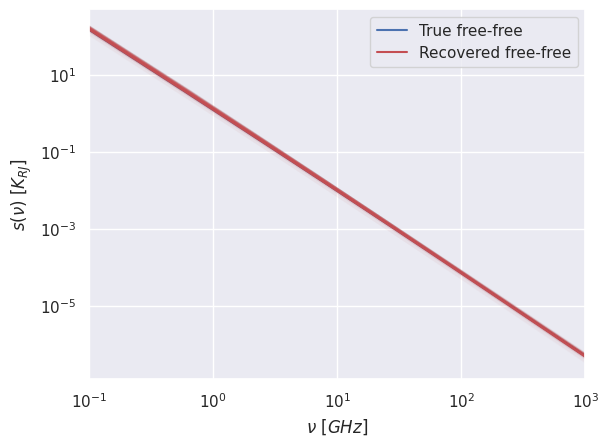

In [ ]:
# Free-free signal
plt.figure()
plt.loglog(plot_nu / 1e9, plot_ff, label='True free-free')
for i, post_signal in enumerate(post_ff):
    plt.loglog(plot_nu / 1e9, post_signal, alpha=0.03, color='r')
plt.loglog(plot_nu / 1e9, mean_ff, alpha=1.0, color='r', label='Recovered free-free')
plt.legend()
plt.xlim(0.1, 1e3)
plt.xlabel(r'$\nu$ $[GHz]$')
plt.ylabel(r'$s(\nu)$ $[K_{RJ}]$')

Text(0, 0.5, '$s(\\nu)$ $[K_{RJ}]$')

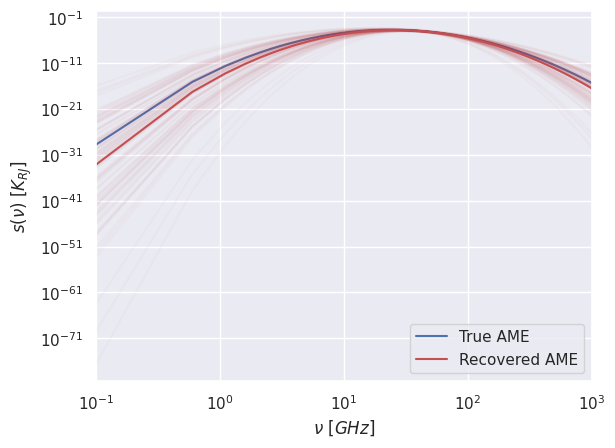

In [ ]:
# AME signal
plt.figure()
plt.loglog(plot_nu / 1e9, plot_ame, label='True AME')
for i, post_signal in enumerate(post_ame):
    plt.loglog(plot_nu / 1e9, post_signal, alpha=0.03, color='r')
plt.loglog(plot_nu / 1e9, mean_ame, alpha=1.0, color='r', label='Recovered AME')
plt.legend()
plt.xlim(0.1, 1e3)
plt.xlabel(r'$\nu$ $[GHz]$')
plt.ylabel(r'$s(\nu)$ $[K_{RJ}]$')

Text(0, 0.5, '$s(\\nu)$ $[K_{RJ}]$')

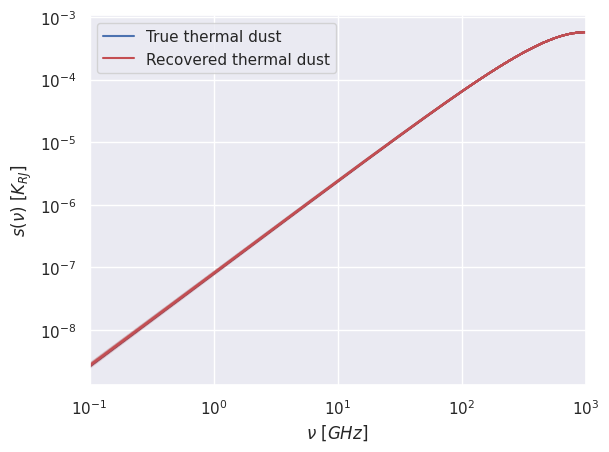

In [ ]:
# Dust signal
plt.figure()
plt.loglog(plot_nu / 1e9, plot_dust, label='True thermal dust')
for i, post_signal in enumerate(post_dust):
    plt.loglog(plot_nu / 1e9, post_signal, alpha=0.03, color='r')
plt.loglog(plot_nu / 1e9, mean_dust, alpha=1.0, color='r', label='Recovered thermal dust')
plt.legend()
plt.xlim(0.1, 1e3)
plt.xlabel(r'$\nu$ $[GHz]$')
plt.ylabel(r'$s(\nu)$ $[K_{RJ}]$')

Text(0, 0.5, '$s(\\nu)$ $[K_{RJ}]$')

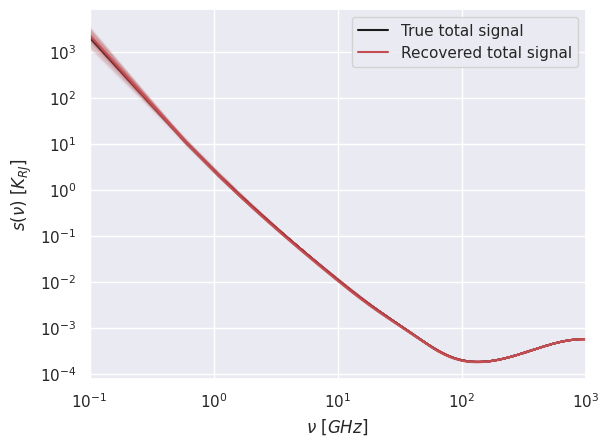

In [ ]:
# Total signal
plt.figure()
plt.loglog(plot_nu / 1e9, plot_total, label='True total signal', color='k')
for i, post_signal in enumerate(post_total):
    plt.loglog(plot_nu / 1e9, post_signal, alpha=0.03, color='r')
plt.loglog(plot_nu / 1e9, mean_total, alpha=1.0, color='r', label='Recovered total signal')
plt.legend()
plt.xlim(0.1, 1e3)
plt.xlabel(r'$\nu$ $[GHz]$')
plt.ylabel(r'$s(\nu)$ $[K_{RJ}]$')